### DATA 620 - Analysis of Network Centrality (Project 1)

Author: Kory Martin  
Date: 2/18/2024

### 1. Introduction

#### Project Instructions

<ul>
<li>For your first project, you are asked to identify and load a network dataset that has some categorical information available for each node.
<li>For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
<li>Compare your centrality measures across your categorical groups.
</ul>
    

#### Project Plan
I chose to use the a movieLens dataset [here](https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html), where we see users and the ratings that they made for a number of movies. Using this data, I am going to build a network of Users that have rated at least 15 of the same movies. This type of analysis can be used to identify similar users - if we consider that the movies that a user watches would suggest a level of similarity.


For this analysis, we will focus on answering the following questions for a network:

<ul>
    <li> How many nodes are in the graph?
    <li> What is the diameter of the Graph?    
    <li> What is the size of the Graph?
    <li> What is the average number of neighbors for nodes? 
    <li> What is the largest number of neighbors that any particular node has?
    <li> What node(s) has the largest number of neighbors?
    <li> What is the fewest number of neighbors that any particular node has?
    <li> What node(s) has the fewest number of neighbors?
</ul>

### 2. Import Libraries

In [1]:
import networkx as net
from networkx import algorithms as algo
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from statistics import mean
import os.path

### 3. Data Preparation

We begin by importing the data for the specific movie titles that were being reviewed. Although this ultimately isn't something that will be included in the final network analysis, it was something that I had initially thought I wanted to specifically analyze. Additionally, the ratings data will be imported

In [2]:
movies_data = pd.read_csv('data/movies.csv')
ratings_data = pd.read_csv('data/ratings.csv')

In [3]:
movies_data.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

Now that we have the movies and the ratings data imported, we will merge the two datasets so that we are able to track exactly which movie titles a specific user rated.

In [4]:
m1 = pd.merge(ratings_data, movies_data, how='left',
        left_on='movieId', right_on='movieId')

Finally, we will then create a more simplified version of our merged dataframe that will only include the data for the user, the movie title and the rating that they gave to that movie

In [5]:
m1_simple = m1.loc[:,['title','userId','rating']]

In [6]:
movie_titles = list(movies_data['title'].unique())

In [7]:
movie_raters = list(ratings_data['userId'].unique())

##### Create genres list

For the output, I want to expand the movies_data dataframe so that we have an entry for each title along with their genres.

In [8]:
movies_data_expanded = []

for i in range(len(movies_data)):

    movie_id = movies_data.loc[i,'movieId']
    movie_title = movies_data.loc[i,'title']

    genres = movies_data.loc[i,'genres'].split("|")
    for genre in genres:
        mini_dict = {}
        mini_dict['movieId'] = movie_id
        mini_dict['title'] = movie_title
        mini_dict['genre'] = genre
        movies_data_expanded.append(mini_dict)

In [9]:
movies_expanded_df = pd.DataFrame(movies_data_expanded)

In [10]:
movie_count = m1_simple.groupby('userId').count().reset_index()

In [11]:
movie_count['pct_watched'] = movie_count['title']/len(movie_titles)

In [12]:
movie_raters_subset = list(movie_count[movie_count['pct_watched'] <= .025]['userId'].unique())

In [13]:
503/len(movie_raters)

0.8245901639344262

In [14]:
m1_sub_titles = list(m1_simple[m1_simple['userId'].isin(movie_raters_subset)]['title'].unique())

##### Create movie pairs

This next block of code is where we will build out the movie pairs for our dataset. The code creates a filtered dataset for the specific user that we are looking at and then creates node relationships based on the movies that are watched by this user

In [15]:
if not os.path.exists('data/movie_pairs.csv'):

    movie_pairs = []
    for user in movie_raters_subset:

        m1_sub = m1_simple.loc[m1_simple['userId'] == user]
        movie_titles = list(m1_sub['title'].unique())
        for i in range(len(movie_titles)):

            movie1 = m1_sub.iloc[i]['title']
            j = i+1
            while j < len(movie_titles):
                movie2 = m1_sub.iloc[j]['title']
                j+=1
                movie_pair = (movie1, movie2)
                movie_pairs.append(movie_pair)

    movie_pairs_df = pd.DataFrame(movie_pairs) 
    movie_pairs_df.to_csv('data/movie_pairs.csv',index=False)
    
else:
    movie_pairs_df = pd.read_csv('data/movie_pairs.csv')

In [21]:
movie_pairs_df = movie_pairs_df.rename(columns={'0':'movie1','1':'movie2'})

In [23]:
movie_pairs_df.head()

movie1                       movie2
0  Toy Story (1995)      Grumpier Old Men (1995)
1  Toy Story (1995)                  Heat (1995)
2  Toy Story (1995)  Seven (a.k.a. Se7en) (1995)
3  Toy Story (1995)   Usual Suspects, The (1995)
4  Toy Story (1995)   From Dusk Till Dawn (1996)

In [24]:
network_edges = []
for i in range(len(movie_pairs_df)):
    mini_tupt = (movie_pairs_df.loc[i,'movie1'],movie_pairs_df.loc[i,'movie2'])
    #print(mini_tupt)
    network_edges.append(mini_tupt)

### 3. Create Network

Now that we have the relationship data established, we will display the network of individuals and from there we can examine different measurements related to this network. 

Some of the questions we will look to examine are:

<ul>
    <li> How many nodes are in the graph?
    <li> What is the diameter of the Graph?    
    <li> What is the size of the Graph?
    <li> What is the average number of neighbors for nodes? 
    <li> What is the largest number of neighbors that any particular node has?
    <li> What node(s) has the largest number of neighbors?
    <li> What is the fewest number of neighbors that any particular node has?
    <li> What node(s) has the fewest number of neighbors?
</ul>

In [95]:
if not os.path.exists('data/network_edges'):
    G = net.Graph()
    G.add_nodes_from(m1_sub_titles)
    G.add_edges_from(network_edges)
    G = net.write_pajek(G,'data/network_edges')
#net.draw(G,with_labels=True, font_size = 6, node_size=300)
#net.draw(G, font_size = 6, node_size=300)
else:
    G = net.read_pajek('data/network_edges')

### 4. Calculate the Centrality

#### Degree Centrality

In [26]:
degree_centrality = net.degree_centrality(G)

In [27]:
centrality_list = []
centrality_list.append(degree_centrality)

In [28]:
degree_centrality_df = pd.DataFrame(centrality_list).transpose().reset_index()

degree_centrality_df = degree_centrality_df.rename(columns={'index':'title',0:'centrality'})

#### Eigenvector Centrality

In [29]:
eigenvector_centrality = net.eigenvector_centrality(G)

In [30]:
centrality_list = []
centrality_list.append(eigenvector_centrality)

In [31]:
eigenvector_centrality_df = pd.DataFrame(centrality_list).transpose().reset_index()

eigenvector_centrality_df = eigenvector_centrality_df.rename(columns={'index':'title',0:'centrality'})

In [32]:
eigenvector_centrality_df.head()

title  centrality
0             Toy Story (1995)    0.047037
1      Grumpier Old Men (1995)    0.023855
2                  Heat (1995)    0.035039
3  Seven (a.k.a. Se7en) (1995)    0.042372
4   Usual Suspects, The (1995)    0.044370

### 5. Network Analysis

<b> a. How many nodes are included in the network?

In [34]:
len(list(G.nodes()))

4894

There are 600 nodes in this network - meaning that of our 610 users with ratings. This represents, 98% of the users in the network

<b> b. What is the diameter of the Graph?

In [35]:
#net.diameter(G)

The diameter of the graph is 3

<b> c. What is the size of the Graph?

In [36]:
G.size()

1145704

There are a total of 1,145,704 connections amongst the users in this network

<b>d.  What is the average and median number of neighbors for nodes?

In [37]:
num_neighbors = [len(list(net.neighbors(G,user))) for user in list(G.nodes())]
numbers_group = [{'title':user, 'num_neighbors':len(list(net.neighbors(G,user)))} for user in list(G.nodes())]
mean_neighbors = mean(num_neighbors)
median_neighbors = np.median(num_neighbors)

In [38]:
pd.DataFrame(numbers_group)[pd.DataFrame(numbers_group)['title'] == 'The Darkest Minds (2018)']

Empty DataFrame
Columns: [title, num_neighbors]
Index: []

In [39]:
print("Mean # of Neighbors per User: ", mean_neighbors)
print("Median # of Neighbors per User: ", median_neighbors)

Mean # of Neighbors per User:  468.20760114425826
Median # of Neighbors per User:  262.5


In our network, users had an average of 94.75 neighbors - or users that they were connected to who watched and rated 15 or more of the same movies. This number is much higher than the median of 60. This suggests that there are number of users who have watched so many movies that they had a larger number of users who watched and rated at least 20 of the same movies.

<b>e. What is the largest number of neighbors that any particular node has?

In [40]:
max_neighbors = max(num_neighbors)
max_neighbors

3426

The largest number of neighbors that any particular node has is 595 which represents

<b>f. What node(s) has the largest number of neighbors?


In [41]:
nodes_with_max = [user for user in list(G.nodes()) if len(list(net.neighbors(G,user))) == max_neighbors]
nodes_with_max

['Matrix, The (1999)']

User 414 is the only user with the maximum number of neighbors in the network

<b>g. What is the fewest number of neighbors that any particular node has?

In [42]:
min_neighbors = min(num_neighbors)
min_neighbors

19

<b>h. What node(s) has the fewest number of neighbors?

In [43]:
nodes_with_min = [user for user in list(G.nodes()) if len(list(net.neighbors(G,user))) == min_neighbors]
nodes_with_min

['Spies Like Us (1985)', 'District 13 (Banlieue 13) (2004)']

In [44]:
len(nodes_with_min)

2

There were 14 users in our network who only had 1 other user that watched at least the same 20 movies as them.

In [45]:
neighbors_df = pd.DataFrame(numbers_group)

In [46]:
neighbors_df = pd.merge(neighbors_df, degree_centrality_df, how='left').rename(columns={'centrality':'degree'})


In [47]:
neighbors_df = pd.merge(neighbors_df, eigenvector_centrality_df, how='left').rename(columns={'centrality':'eigenvector'})

Here we will filter out the movies that are not included in the network

In [48]:
movies_filtered = movies_expanded_df[movies_expanded_df['title'].isin(m1_sub_titles)]

In [49]:
neighbors_expanded = pd.merge(movies_filtered.loc[:,['genre','title']],neighbors_df, how='left')

In [50]:
neighbors_expanded.sort_values(by='num_neighbors', ascending=False).tail(10)

genre                             title  num_neighbors    degree  \
11215     Thriller                  Insurgent (2015)             20  0.004087   
11214       Sci-Fi                  Insurgent (2015)             20  0.004087   
5055         Drama                     Circus (2000)             20  0.004087   
11213       Action                  Insurgent (2015)             20  0.004087   
5056      Thriller                     Circus (2000)             20  0.004087   
10499  Documentary                    Samsara (2011)             20  0.004087   
7780        Comedy              Spies Like Us (1985)             19  0.003883   
8305        Action  District 13 (Banlieue 13) (2004)             19  0.003883   
8306         Crime  District 13 (Banlieue 13) (2004)             19  0.003883   
8307        Sci-Fi  District 13 (Banlieue 13) (2004)             19  0.003883   

       eigenvector  
11215     0.000569  
11214     0.000569  
5055      0.000415  
11213     0.000569  
5056      0.000415  
10499     0.000902  
7780      0.000378  
8305      0.000378  
8306      0.000378  
8307      0.000378

In [51]:
neighbors_expanded[neighbors_expanded['genre'] == 'Drama'].sort_values(by='degree', ascending=False).head(10)

genre                             title  num_neighbors    degree  \
599   Drama               Forrest Gump (1994)           3419  0.698753   
500   Drama               Pulp Fiction (1994)           3353  0.685265   
535   Drama  Shawshank Redemption, The (1994)           3147  0.643164   
3955  Drama            American Beauty (1999)           3010  0.615165   
1255  Drama             Godfather, The (1972)           2946  0.602085   
2856  Drama        Saving Private Ryan (1998)           2939  0.600654   
208   Drama                 Braveheart (1995)           2831  0.578582   
3850  Drama           Sixth Sense, The (1999)           2815  0.575312   
862   Drama           Schindler's List (1993)           2787  0.569589   
4088  Drama                 Fight Club (1999)           2734  0.558757   

      eigenvector  
599      0.050478  
500      0.049426  
535      0.048215  
3955     0.046755  
1255     0.046215  
2856     0.047290  
208      0.046197  
3850     0.045859  
862      0.045543  
4088     0.044346

In [52]:
neighbors_expanded.sort_values(by='degree', ascending=False)

genre                             title  num_neighbors    degree  \
3619      Thriller                Matrix, The (1999)           3426  0.700184   
3618        Sci-Fi                Matrix, The (1999)           3426  0.700184   
3617        Action                Matrix, The (1999)           3426  0.700184   
601            War               Forrest Gump (1994)           3419  0.698753   
598         Comedy               Forrest Gump (1994)           3419  0.698753   
...            ...                               ...            ...       ...   
10499  Documentary                    Samsara (2011)             20  0.004087   
7780        Comedy              Spies Like Us (1985)             19  0.003883   
8305        Action  District 13 (Banlieue 13) (2004)             19  0.003883   
8306         Crime  District 13 (Banlieue 13) (2004)             19  0.003883   
8307        Sci-Fi  District 13 (Banlieue 13) (2004)             19  0.003883   

       eigenvector  
3619      0.050229  
3618      0.050229  
3617      0.050229  
601       0.050478  
598       0.050478  
...            ...  
10499     0.000902  
7780      0.000378  
8305      0.000378  
8306      0.000378  
8307      0.000378  

[11816 rows x 5 columns]

### Centrality

Some of the questions that are of interest would be:

- Find summary metrics for each genre
    - Number of Titles
    - Median number of neighbors
    - Max number of neighbors
    - Min number of neighbors
    - Median degree
    - Max degree
    - Min degree
    - Median eigenvector
    - Max eigenvector
    - Min eigenvector
- What are the 10 most popular movies? (Across all categories)
- What is the most popular movie across each genre?

In [107]:
neighbors_expanded.groupby('genre').agg(
    num_titles = ('title','count'),
    median_neighbors = ('num_neighbors','median'),
    mean_neighbors = ('num_neighbors','mean'),
    max_neighbors = ('num_neighbors','max'),
    min_neighbors = ('num_neighbors','min'),
    median_degree = ('degree','median'),
    mean_degree = ('degree','mean'),
    max_degree = ('degree','max'),
    min_degree = ('degree','min')
    
).reset_index().sort_values(by='max_degree', ascending=False)

genre  num_titles  median_neighbors  mean_neighbors  \
16              Sci-Fi         579             419.0      624.616580   
1               Action        1032             396.5      600.646318   
17            Thriller        1062             322.5      525.063089   
18                 War         208             279.5      523.461538   
15             Romance         909             313.0      507.547855   
8                Drama        2254             252.0      450.492458   
5               Comedy        1812             289.0      482.525938   
6                Crime         608             320.5      554.279605   
2            Adventure         805             436.0      644.226087   
11              Horror         460             230.0      384.504348   
4             Children         406             395.0      564.487685   
9              Fantasy         475             373.0      573.454737   
3            Animation         307             322.0      529.801303   
14             Mystery         323             362.0      540.157895   
13             Musical         191             294.0      536.198953   
12                IMAX         117             582.0      717.880342   
10           Film-Noir          43             328.0      508.720930   
19             Western          81             300.0      500.469136   
7          Documentary         138             151.0      198.862319   
0   (no genres listed)           6             116.5      123.166667   

    max_neighbors  min_neighbors  median_degree  mean_degree  max_degree  \
16           3426             19       0.085633     0.127655    0.700184   
1            3426             19       0.081034     0.122756    0.700184   
17           3426             20       0.065910     0.107309    0.700184   
18           3419             23       0.057122     0.106982    0.698753   
15           3419             20       0.063969     0.103729    0.698753   
8            3419             20       0.051502     0.092069    0.698753   
5            3419             19       0.059064     0.098616    0.698753   
6            3353             19       0.065502     0.113280    0.685265   
2            3250             20       0.089107     0.131663    0.664214   
11           3211             21       0.047006     0.078583    0.656244   
4            2910             24       0.080728     0.115366    0.594727   
9            2910             21       0.076231     0.117199    0.594727   
3            2910             26       0.065808     0.108277    0.594727   
14           2815             22       0.073983     0.110394    0.575312   
13           2664             22       0.060086     0.109585    0.544451   
12           2568             28       0.118945     0.146716    0.524831   
10           2074             22       0.067035     0.103969    0.423871   
19           2043             26       0.061312     0.102283    0.417535   
7            1337             20       0.030860     0.040642    0.273247   
0             243             26       0.023810     0.025172    0.049663   

    min_degree  
16    0.003883  
1     0.003883  
17    0.004087  
18    0.004701  
15    0.004087  
8     0.004087  
5     0.003883  
6     0.003883  
2     0.004087  
11    0.004292  
4     0.004905  
9     0.004292  
3     0.005314  
14    0.004496  
13    0.004496  
12    0.005722  
10    0.004496  
19    0.005314  
7     0.004087  
0     0.005314

In [108]:
top10_titles = neighbors_expanded.sort_values(by='degree', ascending=False).drop_duplicates(subset=['title']).head(10)


In [109]:
top10_titles

genre                                              title  \
3619   Thriller                                 Matrix, The (1999)   
601         War                                Forrest Gump (1994)   
498      Comedy                                Pulp Fiction (1994)   
440      Action          Star Wars: Episode IV - A New Hope (1977)   
970       Crime                   Silence of the Lambs, The (1991)   
534       Crime                   Shawshank Redemption, The (1994)   
1711     Sci-Fi  Star Wars: Episode V - The Empire Strikes Back...   
3955      Drama                             American Beauty (1999)   
1897  Adventure                          Back to the Future (1985)   
1255      Drama                              Godfather, The (1972)   

      num_neighbors    degree  eigenvector  
3619           3426  0.700184     0.050229  
601            3419  0.698753     0.050478  
498            3353  0.685265     0.049426  
440            3250  0.664214     0.049499  
970            3211  0.656244     0.048782  
534            3147  0.643164     0.048215  
1711           3021  0.617413     0.048106  
3955           3010  0.615165     0.046755  
1897           2955  0.603924     0.047135  
1255           2946  0.602085     0.046215

Plot of the Top 10 Titles based on title

<Axes: ylabel='title'>

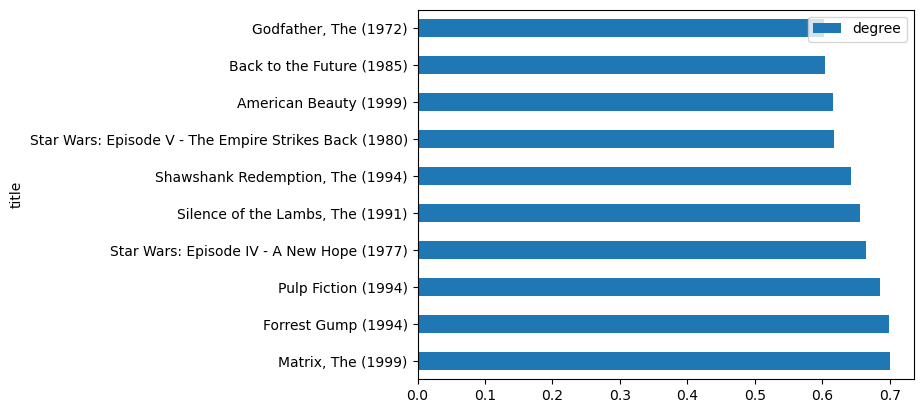

In [111]:
top10_titles.plot(kind='barh', x='title', y='degree')

In [113]:
bottom10_titles = neighbors_expanded.sort_values(by='degree', ascending=False).drop_duplicates(subset=['title']).tail(10)


In [114]:
bottom10_titles

genre                             title  num_neighbors    degree  \
10632      Romance                  Host, The (2013)             20  0.004087   
11154    Adventure                   Delirium (2014)             20  0.004087   
10708       Comedy             Lifeguard, The (2013)             20  0.004087   
4282       Romance      Come See the Paradise (1990)             20  0.004087   
10965        Drama            One I Love, The (2014)             20  0.004087   
5054         Crime                     Circus (2000)             20  0.004087   
11215     Thriller                  Insurgent (2015)             20  0.004087   
10499  Documentary                    Samsara (2011)             20  0.004087   
7780        Comedy              Spies Like Us (1985)             19  0.003883   
8305        Action  District 13 (Banlieue 13) (2004)             19  0.003883   

       eigenvector  
10632     0.000569  
11154     0.000569  
10708     0.000569  
4282      0.000428  
10965     0.000569  
5054      0.000415  
11215     0.000569  
10499     0.000902  
7780      0.000378  
8305      0.000378

Plot of the Bottom 10 Titles based on title

<Axes: ylabel='title'>

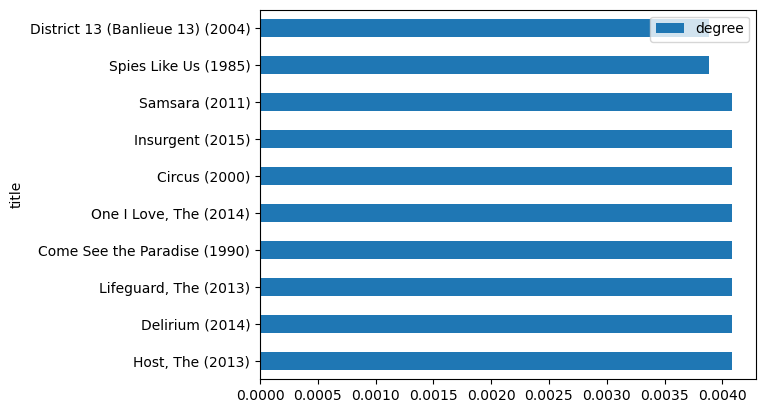

In [115]:
bottom10_titles.plot(kind='barh', x='title', y='degree')

Histogram of degree centrality for the entire network

<Axes: ylabel='Frequency'>

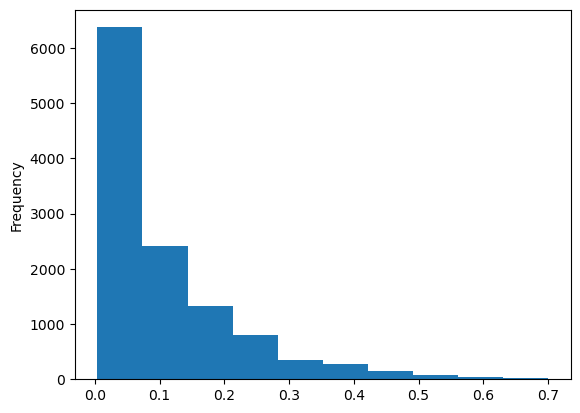

In [112]:
neighbors_expanded['degree'].plot(kind='hist')

### 6. Conclusion

This analysis was helpful in driving some conclusions regarding a specific construction of the network of users who rated movies. One thing that I gained from this process is that network graphs are a way for us to evaluate different relationships amongst different things, but at the same time - as with other types of analysis problems - the real insights are gleaned from the particular questions that we ask of the data and the specific analyses that we apply to the data. Networks are particularly helpful for evaluating relationships and provide a data structure that is best suited for this type of analysis.